# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom. DO NOT download it from the link provided (It may be different).**

Due Date : 03/02 (2nd March), 11:59 PM EST

## Name: Kevin Li

## UNI: kjl2185

## The Dataset
Credit ([Link](https://www.kaggle.com/gamersclub/brazilian-csgo-plataform-dataset-by-gamers-club?select=tb_lobby_stats_player.csv) | [License](https://creativecommons.org/licenses/by-nc-sa/4.0/))

The goal is to predict wins based on in match performace of multiple players. Please use this dataset and this task for all parts of the assignment.

### Features

idLobbyGame - Categorical (The Lobby ID for the game)

idPlayer - Categorical (The ID of the player)

idRooom - Categorical (The ID of the room)

qtKill - Numerical (Number of kills)

qtAssist - Numerical (Number of Assists)

qtDeath - Numerical (Number of Deaths)

qtHs - Numerical (Number of kills by head shot)

qtBombeDefuse - Numerical (Number of Bombs Defuses)

qtBombePlant - Numerical (Number of Bomb plants)

qtTk - Numerical (Number of Team kills)

qtTkAssist - Numerical Number of team kills assists)

qt1Kill - Numerical (Number of rounds with one kill)

qt2Kill - Numerical (Number of rounds with two kill)

qt3Kill - Numerical (Number of rounds with three kill)

qt4Kill - Numerical (Number of rounds with four kill)

qt5Kill - Numerical (Number of rounds with five kill)

qtPlusKill - Numerical (Number of rounds with more than one kill)

qtFirstKill - Numerical (Number of rounds with first kill)

vlDamage - Numerical (Total match Damage)

qtHits - Numerical (Total match hits)

qtShots - Numerical (Total match shots)

qtLastAlive - Numerical (Number of rounds being last alive)

qtClutchWon - Numerical (Number of total clutchs wons)

qtRoundsPlayed - Numerical (Number of total Rounds Played)

descMapName - Categorical (Map Name - de_mirage, de_inferno, de_dust2, de_vertigo, de_overpass, de_nuke, de_train, de_ancient)

vlLevel - Numerical (GC Level)

qtSurvived - Numerical (Number of rounds survived)

qtTrade - Numerical (Number of trade kills)

qtFlashAssist - Numerical (Number of flashbang assists)

qtHitHeadshot - Numerical (Number of times the player hit headshot

qtHitChest - Numerical (Number of times the player hit chest)

qtHitStomach - Numerical (Number of times the player hit stomach)

qtHitLeftAtm - Numerical (Number of times the player hit left arm)

qtHitRightArm - Numerical (Number of times the player hit right arm)

qtHitLeftLeg - Numerical (Number of times the player hit left leg)

qtHitRightLeg - Numerical (Number of times the player hit right leg)

flWinner - Winner Flag (**Target Variable**).

dtCreatedAt - Date at which this current row was added. (Date)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
pd.options.mode.chained_assignment = None

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [4]:
stats_df = pd.read_csv('tb_lobby_stats_player.csv')

In [5]:
stats_df

,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,flWinner,dtCreatedAt
0,1,1,1,5,1,16,2,0,0,0.0,0.0,3,1,0,0,0,0,1,911,25.0,212,0.0,0,17,de_mirage,10,1.0,2.0,0.0,3.0,13.0,4.0,2.0,2.0,1.0,0.0,0,2022-01-21 19:45:44
1,2,1,2,24,3,18,6,0,4,0.0,1.0,9,4,1,1,0,0,3,2933,54.0,597,1.0,1,27,de_nuke,9,8.0,1.0,0.0,7.0,26.0,14.0,2.0,1.0,1.0,3.0,1,2022-02-04 02:09:47
2,3,2,3,6,4,23,2,0,1,0.0,1.0,4,1,0,0,0,0,2,1117,31.0,207,0.0,0,25,de_mirage,2,2.0,3.0,0.0,3.0,15.0,8.0,1.0,2.0,0.0,2.0,0,2021-09-18 18:07:43
3,3,391,27508,10,5,20,4,1,0,0.0,0.0,6,2,0,0,0,0,1,1740,63.0,411,1.0,1,25,de_mirage,15,3.0,4.0,0.0,6.0,27.0,10.0,1.0,7.0,6.0,6.0,1,2021-09-18 18:07:43
4,4,2,4,8,4,26,6,0,2,0.0,0.0,4,2,0,0,0,0,1,1696,51.0,324,0.0,0,30,de_nuke,2,4.0,4.0,2.0,8.0,19.0,12.0,2.0,3.0,2.0,5.0,0,2021-09-27 00:17:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184147,172907,2716,178496,21,3,13,5,1,1,0.0,0.0,8,5,1,0,0,0,3,2610,88.0,524,1.0,0,26,de_vertigo,9,11.0,0.0,0.0,7.0,42.0,26.0,1.0,4.0,6.0,2.0,1,2021-11-27 16:47:57
184148,172908,2716,178497,15,1,22,5,0,1,0.0,0.0,11,2,0,0,0,0,5,2154,63.0,357,0.0,0,29,de_nuke,9,7.0,5.0,0.0,5.0,21.0,21.0,3.0,7.0,2.0,4.0,1,2021-12-10 01:08:48
184149,172909,2716,178498,9,6,23,2,0,3,0.0,0.0,9,0,0,0,0,0,2,1701,59.0,371,0.0,0,27,de_vertigo,9,4.0,2.0,0.0,3.0,25.0,12.0,1.0,5.0,6.0,7.0,0,2022-01-09 21:01:10
184150,172910,2716,178499,15,5,20,6,0,2,0.0,0.0,13,1,0,0,0,0,1,2246,65.0,355,0.0,0,25,de_dust2,9,5.0,3.0,1.0,8.0,22.0,16.0,2.0,8.0,3.0,6.0,0,2022-01-14 17:42:37


**1.2: Plot % of missing values in each column. Would you consider dropping any columns? Assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping - you must remove the dtCreatedAt column)**

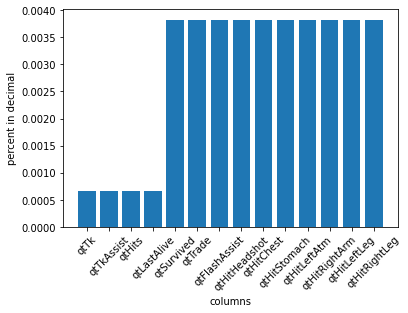

In [6]:
fig = plt.figure()
col = list(stats_df.columns)
nan_num = stats_df.isna().sum()
percent = []
counter = 0
column = []
for c in nan_num:
  per = c / len(stats_df)
  if per:
    percent.append(per)
    column.append(col[counter])
  counter += 1  
plt.bar(column, percent)
plt.xticks(column, rotation=45)
plt.xlabel("columns")
plt.ylabel("percent in decimal")
plt.show()

### *Answer: Since we want the predictions to be independent of idLobbyGame, idPlayer, and idRoom, we definitely need to drop these columns. In terms of dropping columns, I don't think we need to. Instead, I'd say drop rows that have missing values. A lot of the columns have the same percentage of missing values, which is most likely indicating that the missing values are probably coming from the same rows. We can just drop those rows instead of dropping any columns. If we want to train a decision tree, we wouldn't need to impute the missing values since it'd be more efficient and easier to just drop the rows.*

In [7]:
stats_df = stats_df.drop(['idLobbyGame', 'idPlayer', 'idRoom', 'dtCreatedAt'], axis=1)
stats_df = stats_df.dropna()

**1.3: Plot side-by-siide bars of class distribtuion for each category for the categorical feature and the target categories.**

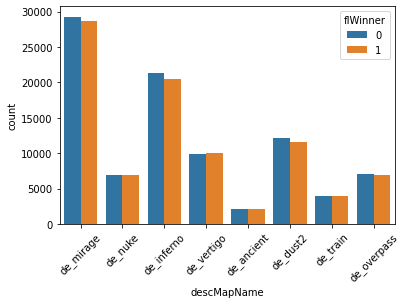

In [8]:
dist = sns.countplot(x="descMapName", hue="flWinner", data=stats_df)
dist.set_xticklabels(dist.get_xticklabels(), rotation=45)
None

**1.4: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [9]:
stats_df_X = stats_df.drop(columns=['flWinner'])
stats_df_Y = stats_df["flWinner"]

stats_df_X_dev, stats_df_X_test, stats_df_Y_dev, stats_df_Y_test = \
train_test_split(stats_df_X, stats_df_Y, test_size=0.2, random_state=42)

### *Answer: I used the standard random 4:1 split on the development set and test set because it's a tried and true way of splitting datasets. I don't believe we should use other splitting methods such as stratified splitting, because those are used when performing classification tasks on highly imbalanced datasets. From 1.3, we can see that the dataset is pretty balanced already, therefore a random splitting would be great in this situation.*

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**

In [10]:
non_cat = (stats_df_X.drop(columns=['descMapName'])).columns
cat = ['descMapName']
preprocess = make_column_transformer((StandardScaler(), non_cat),
                                     (OneHotEncoder(handle_unknown="ignore"), cat),
                                     remainder="passthrough")


### *Answer: We don't <u>NEED</u> to apply scaling on decision trees, since they aren't sensitive to the the variance in the data. We, however do need to One Hot Encode 'descMapName' when preprocessing.*

**1.6: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**

In [11]:
from sklearn.pipeline import make_pipeline

clf = DecisionTreeClassifier(criterion="entropy")
pipe = make_pipeline(preprocess, clf)
pipe.fit(stats_df_X_dev, stats_df_Y_dev)
print(pipe.score(stats_df_X_dev, stats_df_Y_dev))
dec_tree_score = pipe.score(stats_df_X_test, stats_df_Y_test)
print(dec_tree_score)

1.0
0.7315344780594167


Train score 1.0
Test score 0.7315344780594167


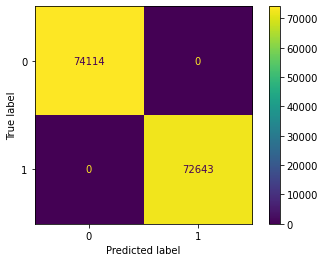

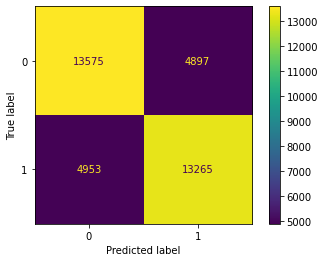

In [12]:
y_train_pred = pipe.predict(stats_df_X_dev)
y_test_pred = pipe.predict(stats_df_X_test)

print(f'Train score {accuracy_score(y_train_pred,stats_df_Y_dev)}')
print(f'Test score {accuracy_score(y_test_pred,stats_df_Y_test)}')
ConfusionMatrixDisplay.from_predictions(stats_df_Y_dev, y_train_pred)
ConfusionMatrixDisplay.from_predictions(stats_df_Y_test, y_test_pred)

### *Answer: It is trivial that the pipeline scores 1.0 on the development set since the pipeline was fitted on it. The test set received a score of around 0.732. Using a confusion matrix to see classification accuracy on this balanced dataset, we ccan see that the performance on the development set and test set are subpar. Since this is a balanced dataset, metrics like precision, recall and F1-score aren't as useful to measure the performance of my model.*

**1.7: Visualize the trained tree until the max_depth 8**

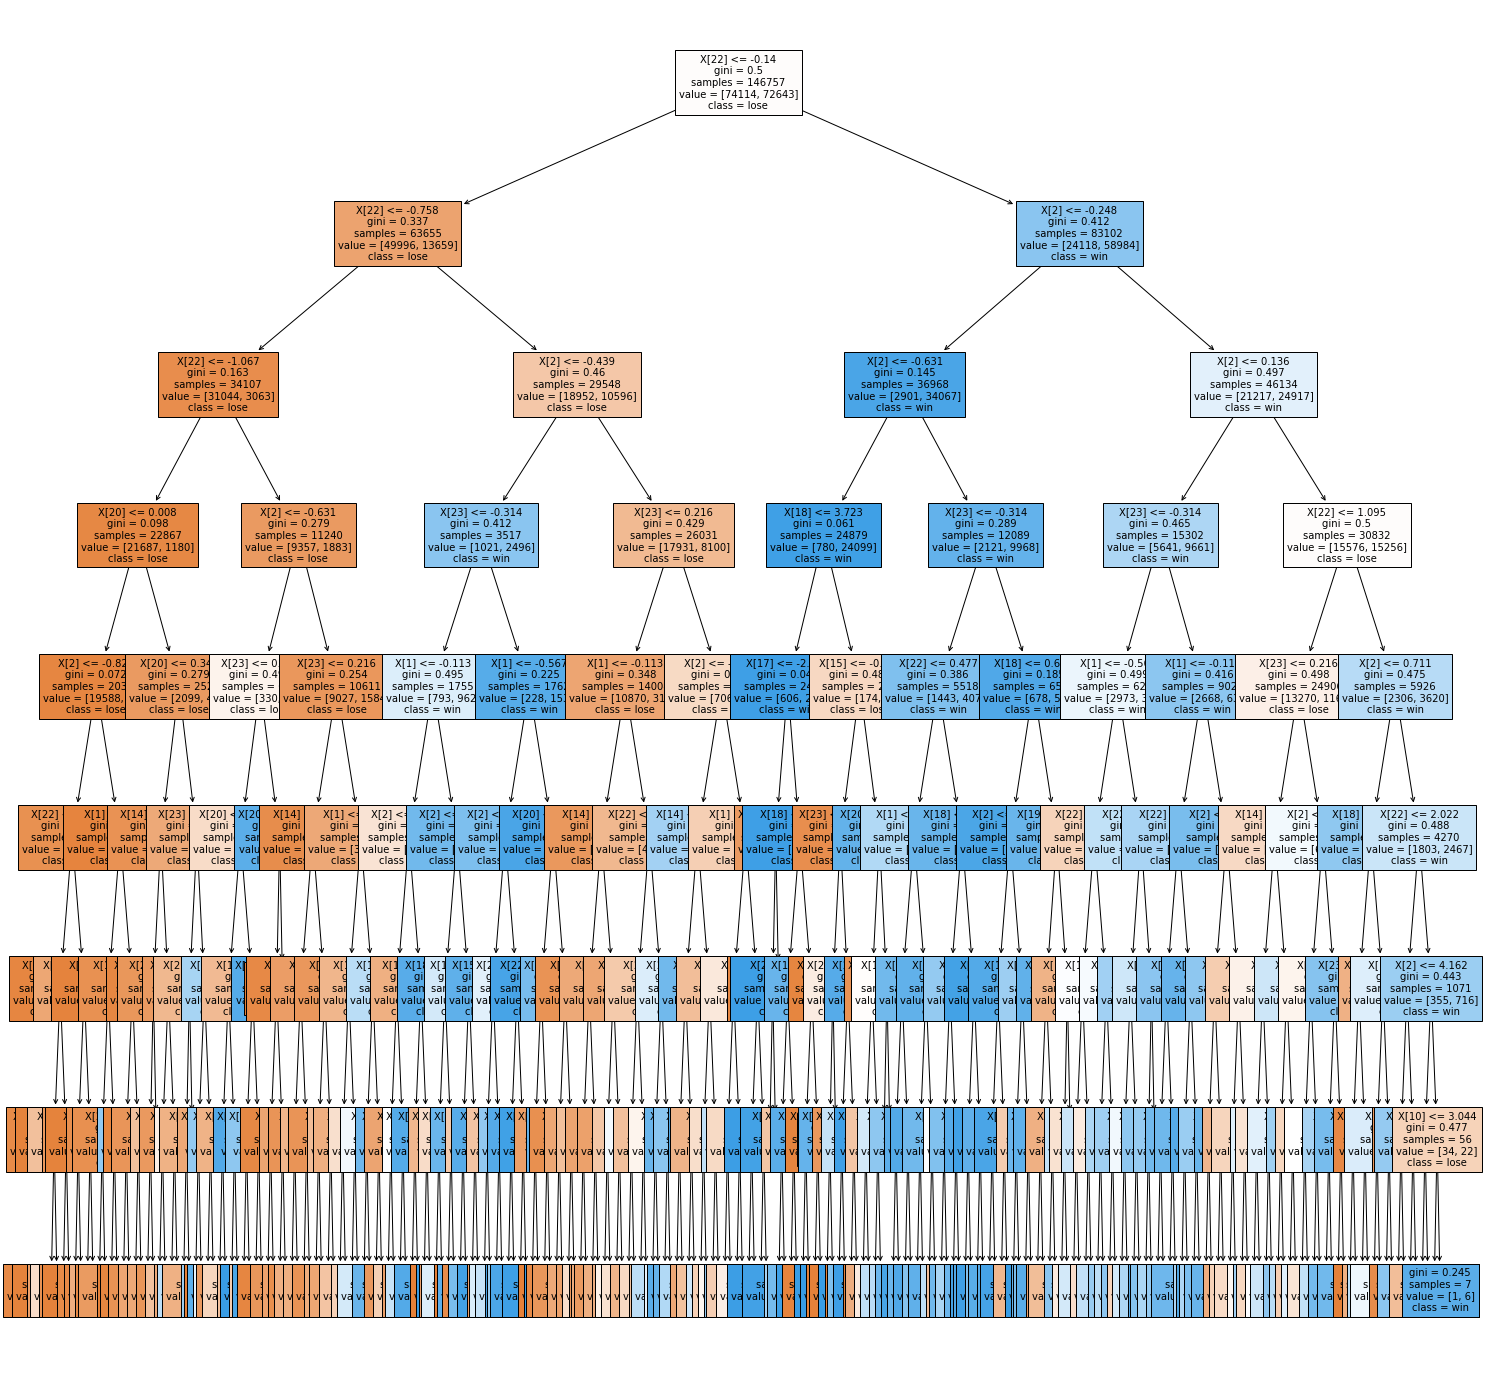

In [13]:
clf = DecisionTreeClassifier(max_depth=8)
early_pipe = make_pipeline(preprocess, clf)
early_pipe.fit(stats_df_X_dev, stats_df_Y_dev)
f_names = stats_df_X.columns
c_names = ["lose", "win"]

fig = plt.figure(figsize=(25, 25))
dec_tree = plot_tree(early_pipe[-1],
                     max_depth=8,
                     class_names=c_names,
                     filled=True,
                     fontsize=10)


**1.8: Prune the tree using one of the techniques discussed in class and evaluate the performance**

In [14]:
stats_df_X_OHE = pd.get_dummies(stats_df_X, dummy_na=True)
stats_df_X_dev_OHE, stats_df_X_test_OHE, stats_df_Y_dev, stats_df_Y_test = \
train_test_split(stats_df_X_OHE, stats_df_Y, test_size=0.2, random_state=0)

In [15]:
path = clf.cost_complexity_pruning_path(stats_df_X_dev_OHE, stats_df_Y_dev)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
last_ten = ccp_alphas[-11:-1]

clfs = []
for ccp_alpha in last_ten:
    clf = DecisionTreeClassifier(random_state=0, max_depth=8,
                                 criterion="entropy", ccp_alpha=ccp_alpha)
    clf.fit(stats_df_X_dev_OHE, stats_df_Y_dev)
    clfs.append(clf)

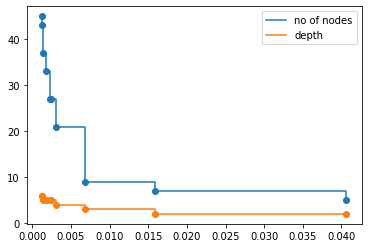

In [16]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(last_ten,node_counts)
plt.scatter(last_ten,depth)
plt.plot(last_ten,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(last_ten,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

### *Let's choose ccp_alpha = 0.003.*

Train score 0.7615718500650736
Test score 0.7631507222676479


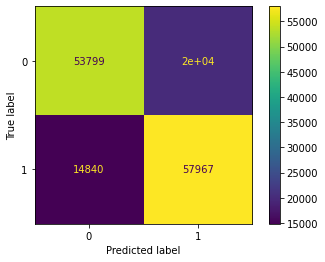

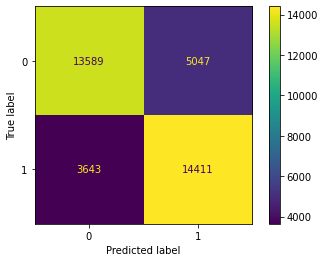

In [17]:
clf_ = DecisionTreeClassifier(random_state=0, max_depth=8,
                                 criterion="entropy", ccp_alpha=0.003)
clf_.fit(stats_df_X_dev_OHE,stats_df_Y_dev)
# print(stats_df_X_dev_OHE.shape)
# print(stats_df_X_test_OHE.shape)
y_train_pred = clf_.predict(stats_df_X_dev_OHE)
y_test_pred = clf_.predict(stats_df_X_test_OHE)

print(f'Train score {accuracy_score(y_train_pred,stats_df_Y_dev)}')
print(f'Test score {accuracy_score(y_test_pred,stats_df_Y_test)}')
ConfusionMatrixDisplay.from_predictions(stats_df_Y_dev, y_train_pred)
ConfusionMatrixDisplay.from_predictions(stats_df_Y_test, y_test_pred)

### *Answer: We can see that the model is not overfitting and performance on test data has improved for test scores.*

**1.9: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

In [18]:
importance = clf_.feature_importances_
features = stats_df_X_OHE
feat_imps = zip(features, importance)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
# print(feats)
# print(imps)
print("Top 3 most important features")
for i in range(3):
  print("Feature " + str(feats[i]) + " with an importance of " + str(imps[i]))

Top 3 most important features
Feature qtSurvived with an importance of 0.6078806077836864
Feature qtDeath with an importance of 0.34956173325097545
Feature qtTrade with an importance of 0.02871138390552081


### *Answer: The number of rounds survived, the number of deaths, and the number of trade kills are the most important features. As a former CSGO gamer, this makes since because for every round you're alive and survive, you create impact and also are able to bring your current gun to the next round, which efficiently increases your team's economy. The number of deaths is also an important feature and is closely related to the number of rounds survived. They basically explain the same situation. Though, the number of deaths is less important than the rounds survived because having a high death count doesn't mean you aren't being impactful in helping your team win. It's more saying you're very aggressive and play for trades, which is very impactful in itself if the team is synergized. That brings us to the number of trade kills. This is important because it shows your ability to create impact off of your teammates' deaths. When they die in a gun fight, but you are able to finish the opponent and "trade", you're effectively creating impact to help your team win.*

## Question 2: Random Forests

In [19]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

In [20]:
rfclf = RandomForestClassifier(criterion="entropy", random_state=100, warm_start=True)
pipe_rf = make_pipeline(preprocess, rfclf)
pipe_rf.fit(stats_df_X_dev, stats_df_Y_dev)
rf_score = pipe_rf.score(stats_df_X_test, stats_df_Y_test)
print(f"Random Forest Classifier score:", rf_score)
print(f"Decision Tree Classifier score:", dec_tree_score)

Random Forest Classifier score: 0.5046334150994821
Decision Tree Classifier score: 0.7315344780594167


Test score 0.5046334150994821


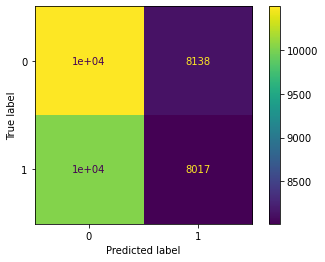

In [21]:
y_test_pred = pipe_rf.predict(stats_df_X_test)

print(f'Test score {accuracy_score(y_test_pred,stats_df_Y_test)}')
ConfusionMatrixDisplay.from_predictions(stats_df_Y_test, y_test_pred)

### *Answer: we can see that Random Forest Classifier score is much lower than the Decision Tree Classifier score. They have around the same test score accuracy as per the confusion matrix.*

**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

### *Answer: Since max_depth is set to none, the nodes are expanded until all leaves are pure, the trees in the trained random forest model should have pure leaves. To verify this, you can iterate through all leaf nodes of each tree in the random forest model and check if the entropy is 0.*

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


### *Answer: I would pick n_estimators and max_depth. I picked n_estimators because increasing the number of trees in the forest decreases the variance of the overall model. It also doesn't contribute to overfitting. I picked max_depth because it'll also prevent overfitting.*

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

### *Answer: For n_estimators, I would choose [50, 75, 100, 125, 150]. For max_depth, I would choose [3, 6, 9, 12, 15]. I chose those n_estimators because the higher we go, we get diminishing returns and higher computational burden. I believe these 5 values are adequate to give the model a performance life. I chose those max_depth because the deeper we go, the more likely it is that it overfits. These values represent an adequate range. The values were also chosen to make grid search more time efficient.*

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [22]:
param_grid = {
    'max_depth': [3, 6, 9, 12, 15],
    'n_estimators': [50, 75, 100, 125, 150]
}

grid_search = GridSearchCV(estimator = rfclf, param_grid = param_grid, 
                           n_jobs = -1, verbose = 5)

grid_search.fit(stats_df_X_dev_OHE, stats_df_Y_dev)
grid_search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'max_depth': 15, 'n_estimators': 150}

### *Answer: The optimal hyperparameters are 15 for max_depth and 150 for n_estimators. As you can see below, the performance improved drastically over the plain-vanilla random forest model.*

In [23]:
opt_rf_score = grid_search.score(stats_df_X_test_OHE, stats_df_Y_test)

print(f"Plain-Vanilla Random Forest Classifier score:", rf_score)
print(f"Optimal Random Forest Classifier score:", opt_rf_score)

Plain-Vanilla Random Forest Classifier score: 0.5046334150994821
Optimal Random Forest Classifier score: 0.7911420005451076


**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

In [24]:
best_rf = grid_search.best_estimator_

importances = best_rf.feature_importances_
features = stats_df_X_OHE
feat_imps = list(zip(features, importances))
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
# print(feats)
# print(imps)
print("Top 3 most important features")
for i in range(3):
  print("Feature " + str(feats[i]) + " with an importance of " + str(imps[i]))

Top 3 most important features
Feature qtSurvived with an importance of 0.2859909994834338
Feature qtDeath with an importance of 0.21536799433497456
Feature qtRoundsPlayed with an importance of 0.07247388777289852


### *Answer: The top 3 most important features of the optimal random forest model is the number of rounds survived, the number of deaths, and the number of rounds played. The first two top features are the same as the decision tree, while the 3rd top most important feature for Decision Tree is the number of trade kills. The optimal random forest model's top 3 feature set makes slightly more sense logically. The difference maker of the number of rounds played should have a higher importance than the number of trade kills you have.*

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. Report on the time taken to do model selection for both the models. Also, report the performance of the test dataset from the optimal models.**

In [25]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [100, 125],
    'learning_rate': [0.1, 0.2]
}

gbc = GradientBoostingClassifier(warm_start=True)

gbc_gdsch = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                           n_jobs = -1, verbose = 5)

gbc_fit = gbc_gdsch.fit(stats_df_X_dev_OHE, stats_df_Y_dev)
print("GradientBoostingClassifier optimal model")
gbc_fit.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoostingClassifier optimal model


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 125}

### *On a specific trial, it took 30 minutes to run GradientBoostingClassifier.*

In [26]:
hgbc = HistGradientBoostingClassifier(warm_start=True)

param_grid = {
    'max_depth': [3, 5],
    'max_iter': [100, 125],
    'learning_rate': [0.1, 0.2]
}

hgbc_gdsch = GridSearchCV(estimator = hgbc, param_grid = param_grid, 
                           n_jobs = -1, verbose = 5)

hgbc_fit = hgbc_gdsch.fit(stats_df_X_dev_OHE, stats_df_Y_dev)
print("HistGradientBoostingClassifier optimal model")
hgbc_fit.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
HistGradientBoostingClassifier optimal model


{'learning_rate': 0.2, 'max_depth': 3, 'max_iter': 125}

### *On a specific trial, it took 2 minutes to run HistGradientBoostingClassifier.*

In [27]:
opt_gbc_score = gbc_fit.score(stats_df_X_test_OHE, stats_df_Y_test)
opt_hgbc_score = hgbc_fit.score(stats_df_X_test_OHE, stats_df_Y_test)

print(f"Optimal GradientBoostingClassifier score:", opt_gbc_score)
print(f"Optimal HistGradientBoostingClassifier score:", opt_hgbc_score)

Optimal GradientBoostingClassifier score: 0.7982556554919596
Optimal HistGradientBoostingClassifier score: 0.7994276369582992


### *The performance of the test dataset from the optimal GradientBoostingClassifier and HistGradientBoostingClassifier models are basically the same, with HistGradientBoostingClassifier slightly better than GradientBoostingClassifier.*

**3.2: Train an XGBoost model by tuning 3 hyperparameters using 5 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [28]:
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [100, 125],
    'learning_rate': [0.1, 0.2]
}

xgb = XGBClassifier(warm_start=True)
xgb_gdsch = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                           n_jobs = -1, verbose = 5)

xgb_gdsch.fit(stats_df_X_dev_OHE, stats_df_Y_dev)
print("XGBoost optimal model")
xgb_gdsch.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:19] WARNING: ../src/learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:11:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost optimal model


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 125}

In [29]:
opt_xgb_score = xgb_gdsch.score(stats_df_X_test_OHE, stats_df_Y_test)

print(f"Optimal GradientBoostingClassifier score:", opt_gbc_score)
print(f"Optimal HistGradientBoostingClassifier score:", opt_hgbc_score)
print(f"Optimal XGBoost score:", opt_xgb_score)

Optimal GradientBoostingClassifier score: 0.7982556554919596
Optimal HistGradientBoostingClassifier score: 0.7994276369582992
Optimal XGBoost score: 0.7989915508312891


### *From above, we can see that they have similar performance scores.*

**3.3: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

### *Answer: From the 5 results in one instance trial, HistGradientBoostingClassifier (0.79942) had the highest performance, with a slight advantage over XGBoost and GradientBoostingClassifier (0.79899 and 0.79825), and major advantage over DecisionTreeClassifier (0.73153) and the worst model, an un-optimized RandomForestClassifier (0.50463). The difference between the best and the worst is 0.29479. Among the 5 models, I would definitely choose HistGradientBoostingClassifier, because not only does it tend to perform the best, it also has the best run time, as shown above.*

**3.4: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

In [30]:
best_xgb = xgb_gdsch.best_estimator_

importances = best_xgb.feature_importances_
features = stats_df_X_OHE
feat_imps = list(zip(features, importances))
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
# print(feats)
# print(imps)
print("Top 3 most important features")
for i in range(3):
  print("Feature " + str(feats[i]) + " with an importance of " + str(imps[i]))

Top 3 most important features
Feature qtSurvived with an importance of 0.42557883
Feature qtDeath with an importance of 0.1604003
Feature qtAssist with an importance of 0.049555138


### *Answer: The top 3 most important features of the optimal XGBoost model is the number of rounds survived, the number of deaths, and the number of assists. The top 2 for XGBoost, Random Forest, and Decision Tree are all the same. The deciding feature is the 3rd. Comparing the number of assists, the number of rounds played, and the number of trade kills, I would say the number of assists should be the most important, as that's the biggest impact factor in determining how much you help your team win. Thus, XGBoost model would be the one I trust the most.*

**3.5: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [31]:
top_7 = XGBClassifier(warm_start=True)
top7_gdsch = GridSearchCV(estimator = top_7, param_grid = param_grid, 
                           n_jobs = -1, verbose = 5)

X_dev_top_7 = stats_df_X_dev_OHE[list(feats[:7])]
top7_gdsch.fit(X_dev_top_7, stats_df_Y_dev)
print("top 7 features XGBoost optimal model")
top7_gdsch.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:37] WARNING: ../src/learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:18:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
top 7 features XGBoost optimal model


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 125}

In [32]:
X_test_top_7 = stats_df_X_test_OHE[list(feats[:7])]
opt_top7_score = top7_gdsch.score(X_test_top_7, stats_df_Y_test)

print(f"Optimal XGBoost score:", opt_xgb_score)
print(f"Optimal top 7 features XGBoost score:", opt_top7_score)

Optimal XGBoost score: 0.7989915508312891
Optimal top 7 features XGBoost score: 0.7989915508312891


### *Answer: From the above, we can see that the top 7 features data set for the optimal XGBoost has the same performance as the optimal XGBoost model trained in Q3.2. The performance was the same because the top 7 features are the influencing features to the model.*

## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [33]:
from sklearn.metrics import brier_score_loss

y_test_pred = best_xgb.predict(stats_df_X_test_OHE)
brier_score_loss(stats_df_Y_test, y_test_pred, pos_label=2)

0.4750885799945489

**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods**

In [34]:
# !pip uninstall scikit-learn -y

# !pip install -U scikit-learn

In [36]:
import sklearn
import xgboost
# !pip install xgboost --upgrade
print(xgboost.__version__)
print(sklearn.__version__)

1.5.2
1.0.2


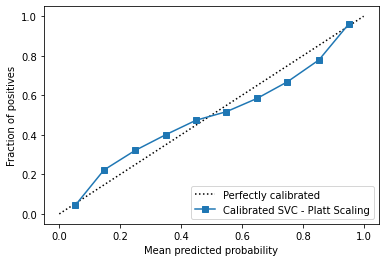

In [38]:
import xgboost
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
# import sklearn

X_train, X_calib, y_train, y_calib = train_test_split(
    stats_df_X_dev_OHE, stats_df_Y_dev, test_size=0.2, random_state=42)

cal_svc = CalibratedClassifierCV(best_xgb, cv="prefit", method="sigmoid")
cal_svc.fit(X_calib, y_calib)
display = CalibrationDisplay.from_estimator(
    cal_svc, stats_df_X_test_OHE, stats_df_Y_test, 
    n_bins=10, name='Calibrated SVC - Platt Scaling')

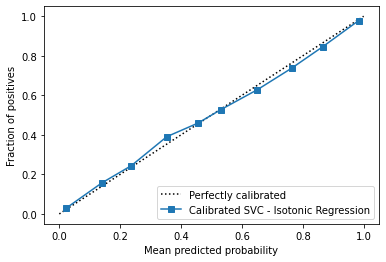

In [39]:
cal_svc_iso = CalibratedClassifierCV(best_xgb, cv="prefit", method="isotonic")
cal_svc_iso.fit(X_calib, y_calib)
display_iso = CalibrationDisplay.from_estimator(
    cal_svc_iso, stats_df_X_test_OHE, stats_df_Y_test, 
    n_bins=10, name='Calibrated SVC - Isotonic Regression')

**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [41]:
y_test_pred_platt = cal_svc.predict(stats_df_X_test_OHE)
platt_brier = brier_score_loss(stats_df_Y_test, y_test_pred_platt, pos_label=2)
print("Platt Scaling Brier Score:", platt_brier)

y_test_pred_iso = cal_svc_iso.predict(stats_df_X_test_OHE)
iso_brier = brier_score_loss(stats_df_Y_test, y_test_pred_iso, pos_label=2)
print("Isotonic Regression Brier Score:", iso_brier)

Platt Scaling Brier Score: 0.4773235213954756
Isotonic Regression Brier Score: 0.49910057236304173


### *Answer: Both calibration methods helped in having better predicted probabilities as we can see via the brier scores.*